This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Autoencoder /  Classify 6 Basic Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os
import collections

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 509 µs (started: 2021-12-07 04:23:22 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.84 ms (started: 2021-12-07 04:23:22 +00:00)


### Load pretrained autoencoder.

In [5]:
# Create autoencoder model (skeleton) for loading pretrained weights.

def create_autoencoder():
    # Define the model
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #2nd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #3rd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    #1st deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    #2nd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))

    #3rd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))    

    model.add(Conv2D(3,(3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

time: 5.09 ms (started: 2021-12-07 04:23:22 +00:00)


In [6]:
# Load pretrained autoencoder weights.

checkpoint_path = "./model/autoencoder.ckpt"
autoencoder = create_autoencoder()
autoencoder.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

time: 1.74 s (started: 2021-12-07 04:23:22 +00:00)


### The below code is for creating training data tfrecord and idx file from images. (We do not use the below code in this jupyter notebook since we import tfrecords directly.)

```python
from itertools import islice
from subprocess import call

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#def _float_feature(value):
#    """Returns a float_list from a float / double."""
#    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# Create a dictionary with relevant features.

def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def gen_tfrecord_idx(tfrecord_file, dict_label, tfrecord_idx):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in dict_label.items():
            fname = "./image/" + filename
            image_string = open(fname, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

    tfrecord2idx_script = "tfrecord2idx"

    if not os.path.isfile(tfrecord_idx):
        call([tfrecord2idx_script, tfrecord_file, tfrecord_idx])


#--------------------------------------------
# VALID DATA: Load labels, check headers, check data shape.

df_label_valid = pd.read_csv('label/label_6_basic_emo_valid.csv')
print("valid columns:", df_label_valid.columns)
print("valid shape:", df_label_valid.shape)

# Place labels into a dictionary.

dict_label_valid = {}
for idx, row in df_label_valid.iterrows():
    dict_label_valid[row['img_id']] = list(row['angry':'sad'].values)
len(dict_label_valid)

#--------------------------------------------
# Create VALID tfrecord & idx files from jpg images.

tfrecord_file_valid = './tfrecords/6_basic_emo_valid.tfrecords'
tfrecord_idx_valid = './tfrecords/6_basic_emo_valid.idx'

gen_tfrecord_idx(tfrecord_file_valid, dict_label_valid, tfrecord_idx_valid)

#--------------------------------------------
# TRAIN DATA: Load labels, check headers, check data shape.

df_label_train = pd.read_csv('label/label_6_basic_emo_train.csv')
print("train columns:", df_label_train.columns)
print("train shape:", df_label_train.shape)

# Place labels into a dictionary.

dict_label_train = {}
for idx, row in df_label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['angry':'sad'].values)
len(dict_label_train)

#--------------------------------------------
# Create TRAIN tfrecord & idx files from jpg images.

tfrecord_file_train = './tfrecords/6_basic_emo_train.tfrecords'
tfrecord_idx_train = './tfrecords/6_basic_emo_train.idx'

gen_tfrecord_idx(tfrecord_file_train, dict_label_train, tfrecord_idx_train) 

#--------------------------------------------
# TEST DATA: Load labels, check headers, check data shape.

df_label_test = pd.read_csv('label/label_6_basic_emo_test.csv')
print("test columns:", df_label_test.columns)
print("test shape:", df_label_test.shape)

# Place labels into a dictionary.

dict_label_test = {}
for idx, row in df_label_test.iterrows():
    dict_label_test[row['img_id']] = list(row['angry':'sad'].values)
len(dict_label_test)

#-------------------------------------------
# Create TEST tfrecord & idx files from jpg images.

tfrecord_file_test = './tfrecords/6_basic_emo_test.tfrecords'
tfrecord_idx_test = './tfrecords/6_basic_emo_test.idx'

gen_tfrecord_idx(tfrecord_file_test, dict_label_test, tfrecord_idx_test) 

# OUTPUT
# valid columns: Index(['img_id', 'clip_id', 'angry', 'disgusted', 'surprised', 'fearful',
#       'happy', 'sad'],
#       dtype='object')
# valid shape: (1282, 8)
# train columns: Index(['img_id', 'clip_id', 'angry', 'disgusted', 'surprised', 'fearful',
#       'happy', 'sad'],
#       dtype='object')
# train shape: (10249, 8)
# test columns: Index(['img_id', 'clip_id', 'angry', 'disgusted', 'surprised', 'fearful',
#       'happy', 'sad'],
#       dtype='object')
# test shape: (1282, 8)
```  

### Load label data.

In [7]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_6_basic_emo.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All class:", len(LABELS))

label_valid = pd.read_csv('label/label_6_basic_emo_valid.csv')
label_train = pd.read_csv('label/label_6_basic_emo_train.csv')
label_test = pd.read_csv('label/label_6_basic_emo_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'angry', 'disgusted', 'surprised', 'fearful',
       'happy', 'sad'],
      dtype='object')
(12813, 8)
LABELS= ['angry', 'disgusted', 'surprised', 'fearful', 'happy', 'sad']
All class: 6
TRAIN_DATA_SIZE: 10249
VALID_DATA_SIZE: 1282
TEST_DATA_SIZE: 1282
time: 38.2 ms (started: 2021-12-07 04:23:23 +00:00)


### Calculate class weights.

In [8]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['angry':'sad'].values)
len(dict_label_train)

10249

time: 2.09 s (started: 2021-12-07 04:23:24 +00:00)


In [9]:
y_train_ls = list(dict_label_train.values())
#y_train_ls

time: 534 µs (started: 2021-12-07 04:23:26 +00:00)


In [10]:
y_train_ints = [y.index(1) for y in y_train_ls]
#y_train_ints

time: 19.3 ms (started: 2021-12-07 04:23:26 +00:00)


In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train_ints),
                                                  y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.2815040650406504,
 1: 18.3673835125448,
 2: 0.7868109933978198,
 3: 7.6257440476190474,
 4: 11.46420581655481,
 5: 1.106325561312608}

time: 20.7 ms (started: 2021-12-07 04:23:26 +00:00)


In [12]:
class_weights

array([ 0.28150407, 18.36738351,  0.78681099,  7.62574405, 11.46420582,
        1.10632556])

time: 2.41 ms (started: 2021-12-07 04:23:26 +00:00)


In [13]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

time: 1.88 ms (started: 2021-12-07 04:23:26 +00:00)


In [14]:
multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier
adjusted_cw

array([0.14075203, 9.18369176, 0.3934055 , 3.81287202, 5.73210291,
       0.55316278])

time: 5.16 ms (started: 2021-12-07 04:23:26 +00:00)


In [15]:
log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)
sum_weights
custom_class_weights = log_weights / sum_weights
custom_class_weights

array([0.11638164, 0.22366313, 0.13195144, 0.18733217, 0.20259518,
       0.13807644])

time: 5.4 ms (started: 2021-12-07 04:23:26 +00:00)


In [16]:
custom_class_weights += adjusted_cw
custom_class_weights

array([0.25713368, 9.40735489, 0.52535693, 4.00020419, 5.93469809,
       0.69123922])

time: 3.16 ms (started: 2021-12-07 04:23:26 +00:00)


In [17]:
class_weight_dict = dict(enumerate(custom_class_weights))
class_weight_dict

{0: 0.25713367600252574,
 1: 9.407354888012607,
 2: 0.5253569344678802,
 3: 4.0002041936980595,
 4: 5.934698087278068,
 5: 0.6912392187757267}

time: 3.27 ms (started: 2021-12-07 04:23:26 +00:00)


### Define training pipeline.

In [18]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([6], tfrec.int64,  6)},
             path = ['./tfrecords/6_basic_emo_train.tfrecords'],
             index_path = ['./tfrecords/6_basic_emo_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 91 ms (started: 2021-12-07 04:23:26 +00:00)


### Define validation pipeline.

In [19]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([6], tfrec.int64,  6)},
             path = ['./tfrecords/6_basic_emo_valid.tfrecords'],
             index_path = ['./tfrecords/6_basic_emo_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.82 ms (started: 2021-12-07 04:23:26 +00:00)


### Train autoencoder model for classifying 6 basic emotions.

In [20]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 6))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)
    
    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
              (batch_size_valid, 6))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)    

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)     
       
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.softmax
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)

        number_of_classes = 6
        
        inputs = keras.Input(shape=(64, 64, 3))
        x = autoencoder(inputs, training=False)   # Fix autoencoder weights.
        flat = keras.layers.Flatten()(x)
        fc1 = keras.layers.Dense(number_of_classes, activation='relu',
                             kernel_initializer=initializer)(flat)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)    
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()
        
        # To save the model weights, uncomment the below code.        
        #checkpoint_path = "./model/cp_clf_6_emo.ckpt"
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
        #                                         save_weights_only=True,
        #                                         verbose=1)
        
        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
       
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size,
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          class_weight=class_weight_dict,
                          callbacks=[es_callback])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         48003     
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 73734     
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
Total params: 121,779
Trainable params: 121,779
Non-trainable params: 0
_______________________________________________________

160/160 [==============================] - 3s 20ms/step - loss: 0.9488 - accuracy: 0.4462 - val_loss: 1.3570 - val_accuracy: 0.5727
Epoch 50/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.9510 - accuracy: 0.4444 - val_loss: 1.3230 - val_accuracy: 0.5609
Epoch 51/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.9413 - accuracy: 0.4434 - val_loss: 1.3598 - val_accuracy: 0.5602
Epoch 52/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.9471 - accuracy: 0.4461 - val_loss: 1.3619 - val_accuracy: 0.6000
Epoch 53/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.9470 - accuracy: 0.4511 - val_loss: 1.3192 - val_accuracy: 0.5781
Epoch 54/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.9511 - accuracy: 0.4511 - val_loss: 1.3440 - val_accuracy: 0.5680
Epoch 55/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.9553 - accuracy: 0.4465 - val_loss: 1.3358 - val_accuracy:

160/160 [==============================] - 3s 21ms/step - loss: 0.8792 - accuracy: 0.4726 - val_loss: 1.2082 - val_accuracy: 0.6523
Epoch 106/1000
160/160 [==============================] - 3s 21ms/step - loss: 0.9037 - accuracy: 0.4622 - val_loss: 1.2087 - val_accuracy: 0.6234
Epoch 107/1000
160/160 [==============================] - 3s 20ms/step - loss: 0.8968 - accuracy: 0.4639 - val_loss: 1.2088 - val_accuracy: 0.6359
time: 5min 48s (started: 2021-12-07 04:23:26 +00:00)


In [21]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 701 µs (started: 2021-12-07 04:29:15 +00:00)


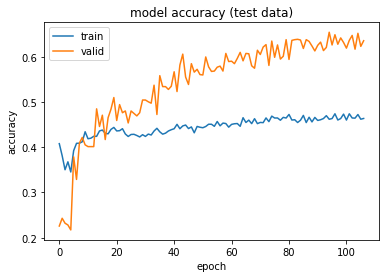

time: 181 ms (started: 2021-12-07 04:29:15 +00:00)


In [22]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (test data)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

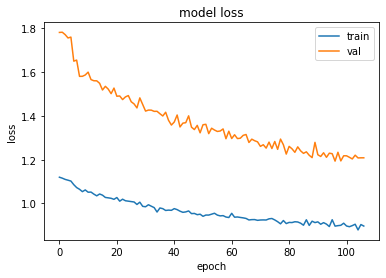

time: 128 ms (started: 2021-12-07 04:29:15 +00:00)


In [23]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [24]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([6], tfrec.int64,  6)},
             path = ['./tfrecords/6_basic_emo_test.tfrecords'],
             index_path = ['./tfrecords/6_basic_emo_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.94 ms (started: 2021-12-07 04:29:15 +00:00)


### Check test data accuracy.

In [25]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 6))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

1282/1282 [==============================] - 9s 6ms/step - loss: 1.1872 - accuracy: 0.6693
Test accuracy: 0.6692667603492737
A test output from the last layer: [0.29977646 0.0486406  0.24614707 0.08626368 0.21579914 0.10337303]
Index of the maximum value: 0
Label: angry
time: 8.9 s (started: 2021-12-07 04:29:15 +00:00)


In [26]:
predictions

array([[0.29977646, 0.0486406 , 0.24614707, 0.08626368, 0.21579914,
        0.10337303],
       [0.08639381, 0.16399723, 0.15350595, 0.15296331, 0.06901735,
        0.37412232],
       [0.19276166, 0.10116758, 0.20170936, 0.17032175, 0.1657133 ,
        0.16832644],
       [0.5450536 , 0.00606751, 0.30794838, 0.00634239, 0.11366145,
        0.02092662],
       [0.53574526, 0.009619  , 0.28744206, 0.00848251, 0.13313717,
        0.02557391]], dtype=float32)

time: 3.05 ms (started: 2021-12-07 04:29:24 +00:00)


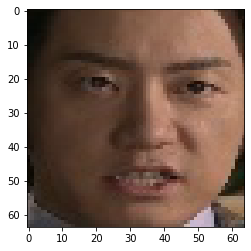

time: 200 ms (started: 2021-12-07 04:29:24 +00:00)


In [27]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [28]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[1, 0, 0, 0, 0, 0]])>

time: 2.57 ms (started: 2021-12-07 04:29:24 +00:00)


In [29]:
data

(<tf.Tensor: shape=(1, 64, 64, 3), dtype=float32, numpy=
 array([[[[0.03921569, 0.03529412, 0.01176471],
          [0.05098039, 0.04705882, 0.02352941],
          [0.04705882, 0.05098039, 0.02352941],
          ...,
          [0.14509805, 0.08627451, 0.05882353],
          [0.08235294, 0.0627451 , 0.03137255],
          [0.09411765, 0.07450981, 0.04313726]],
 
         [[0.03921569, 0.03529412, 0.01176471],
          [0.04313726, 0.03921569, 0.01568628],
          [0.03529412, 0.03921569, 0.01176471],
          ...,
          [0.17254902, 0.11372549, 0.08627451],
          [0.08627451, 0.06666667, 0.03529412],
          [0.09411765, 0.07450981, 0.04313726]],
 
         [[0.04313726, 0.04313726, 0.02745098],
          [0.04313726, 0.04313726, 0.02745098],
          [0.03137255, 0.04313726, 0.02352941],
          ...,
          [0.21568628, 0.12941177, 0.09411765],
          [0.11372549, 0.06666667, 0.03529412],
          [0.15294118, 0.10588235, 0.07450981]],
 
         ...,
 
         

time: 8.18 ms (started: 2021-12-07 04:29:24 +00:00)


In [30]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

time: 5.45 s (started: 2021-12-07 04:29:24 +00:00)


In [31]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 491 ms (started: 2021-12-07 04:29:30 +00:00)


In [32]:
true_test.shape

(1282, 6)

time: 2.4 ms (started: 2021-12-07 04:29:30 +00:00)


In [33]:
from sklearn.metrics import confusion_matrix

pred_test_ls = []
true_test_ls = []
for (pred, true) in zip(pred_test, true_test):
    pred_test_ls.append(np.argmax(pred))
    true_test_ls.append(np.argmax(true))

cf_matrix_test = confusion_matrix(true_test_ls, pred_test_ls)
cf_matrix_test

array([[613,   0,  78,  31,  30,   7],
       [ 12,   0,   0,   0,   0,   0],
       [ 83,   1, 154,  24,   2,   8],
       [  0,   0,   6,  21,   1,   0],
       [  7,   0,   0,   0,  11,   0],
       [ 64,   1,  22,  46,   1,  59]])

time: 29.1 ms (started: 2021-12-07 04:29:30 +00:00)


Text(33.0, 0.5, 'True')

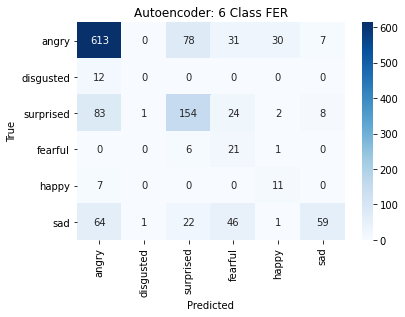

time: 374 ms (started: 2021-12-07 04:29:30 +00:00)


In [34]:
import seaborn as sns

sns.heatmap(cf_matrix_test, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('Autoencoder: 6 Class FER')
plt.xlabel('Predicted')
plt.ylabel('True')

### Check train data accuracy.

In [35]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 6))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
    #with strategy.scope():        
        # Create dataset
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        loss, acc = clf.evaluate(ds_train, steps=TRAIN_DATA_SIZE)
        print("Train accuracy:", acc)
        #predictions = clf.predict(ds_train.take(1))
        #print("A test output from the last layer:", predictions[0])
        #print("Index of the maximum value:", np.argmax(predictions[0]))
        #print("Label:", LABELS[np.argmax(predictions[0])])

10249/10249 [==============================] - 65s 6ms/step - loss: 1.1706 - accuracy: 0.6695
Train accuracy: 0.6695287227630615
time: 1min 5s (started: 2021-12-07 04:29:31 +00:00)


In [36]:
pred_train = clf.predict(ds_train.take(TRAIN_DATA_SIZE))

time: 41.8 s (started: 2021-12-07 04:30:36 +00:00)


In [37]:
true_train = np.concatenate([y for x, y in ds_train.take(TRAIN_DATA_SIZE)], axis=0)

time: 3.63 s (started: 2021-12-07 04:31:18 +00:00)


In [38]:
true_train.shape

(10249, 6)

time: 2.48 ms (started: 2021-12-07 04:31:22 +00:00)


In [39]:
pred_train_ls = []
true_train_ls = []
for (pred, true) in zip(pred_train, true_train):
    pred_train_ls.append(np.argmax(pred))
    true_train_ls.append(np.argmax(true))

cf_matrix_train = confusion_matrix(true_train_ls, pred_train_ls)
cf_matrix_train

array([[4823,    4,  622,  245,  305,   69],
       [  76,   17,    0,    0,    0,    0],
       [ 596,    2, 1322,  185,   40,   26],
       [  14,    0,   19,  189,    0,    2],
       [  50,    0,    1,    0,   98,    0],
       [ 444,    5,  253,  416,   13,  413]])

time: 85.1 ms (started: 2021-12-07 04:31:22 +00:00)


Text(33.0, 0.5, 'True')

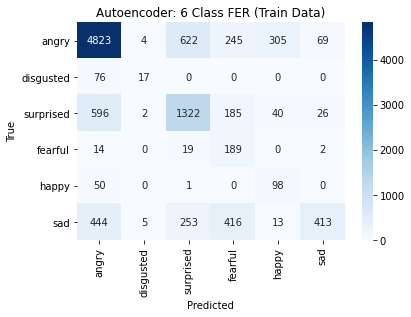

time: 348 ms (started: 2021-12-07 04:31:22 +00:00)


In [40]:
sns.heatmap(cf_matrix_train, annot=True, cmap='Blues', xticklabels=LABELS, yticklabels=LABELS, fmt='g')
plt.title('Autoencoder: 6 Class FER (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('True')